#### Imports

In [1]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import transform


#### Fonctions utilitaires pour parcourir les images

In [2]:
common_path = "../chest_Xray/"
images_files = os.listdir(common_path)
subfolders = ["train","val","test"]
categories = ["NORMAL","PNEUMONIA"]

def browse_imgs(img_callback, path_folder_callback = None, limit_size = None):
    for subfolder in subfolders:
        for category in categories:
            folder_path = os.path.join(common_path, subfolder, category)
            images_files = os.listdir(folder_path)
            if path_folder_callback is not None:
                path_folder_callback(folder_path, images_files)
            array_limit = limit_size if limit_size is not None else len(images_files)
            for file_name in images_files[:array_limit]:
                if not file_name.endswith(".jpeg"):
                    continue
                image_path = os.path.join(folder_path,file_name)
                img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                img_callback(img, category, file_name)

                
def display_imgs(imgs, titles = [], plot_size = (1,1), figsize = (10,8)):
    fig = plt.figure(figsize=figsize)
    index = 0
    for image, title in zip(imgs, titles):
        index += 1
        ax = fig.add_subplot(plot_size[0], plot_size[1], index) 
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        if titles is not None:
            ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [3]:
all_images = []
all_categories = []

datasetX = []
datasetY = []

image_size = (200, 200)

def load_datasets(img, category, file_name):
    if category == "PNEUMONIA":
        if "virus" in file_name:
            category = "VIRUS PNEUMONIA"
        elif "bacteria" in file_name:
            category = "BACTERIA PNEUMONIA"
    else:
        category = "NORMAL"
    
    new_img = cv2.resize(img, image_size)
    all_images.append(new_img)
    all_categories.append(category)

browse_imgs(load_datasets)

##### Doubler le dataset d'images NORMAL

In [4]:
def rotate_image(image, angle):
    return transform.rotate(image, angle)

def flip_image(image):
    return image[:, ::-1]

normal_indice = []
print("Normal indices size : ", len(normal_indice))

# Créer une liste pour stocker les indices des images "NORMAL"
normal_indice = [i for i, category in enumerate(all_categories) if category == "NORMAL"]

print("Normal indices size : ", len(normal_indice))

# Pour chaque image "NORMAL"...
for i in normal_indice:
    img = all_images[i]

    # Effectuer une rotation de 20 degrés, redimensionner l'image et l'ajouter à la liste de toutes les images
    rotated_img = rotate_image(img, 20)
    resized_rotated_img = cv2.resize(rotated_img, image_size)
    all_images.append(resized_rotated_img)
    all_categories.append("NORMAL")

    # Effectuer un retournement horizontal, redimensionner l'image et l'ajouter à la liste de toutes les images
    flipped_img = flip_image(img)
    resized_flipped_img = cv2.resize(flipped_img, image_size)
    all_images.append(resized_flipped_img)
    all_categories.append("NORMAL")

# Convert the list of all images to a numpy array
datasetX = np.array(all_images)

def use_all_dataset():
    global datasetX, datasetY
    datasetX = np.array(all_images)
    datasetY = np.array(all_categories)

use_all_dataset()
print("Dataset all shape : ", datasetX.shape)

Normal indices size :  0
Normal indices size :  1583
Dataset all shape :  (9022, 200, 200)


#### Classification Report

In [51]:
from sklearn.metrics import classification_report

# Génération du rapport de classification
report = classification_report(testy, y_pred, target_names=labels)
print(report)

                    precision    recall  f1-score   support

            NORMAL       0.69      0.82      0.75       549
   VIRUS PNEUMONIA       0.94      0.80      0.87       956
BACTERIA PNEUMONIA       0.74      0.77      0.76       897

          accuracy                           0.80      2402
         macro avg       0.79      0.80      0.79      2402
      weighted avg       0.81      0.80      0.80      2402



#### CNN - Convolution Neural Network

##### Les imports

In [4]:
import visualkeras as vk
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

##### Le modèle

Convolution = mettre en évidence les caractéristiques de l'image.

Poolling = réduire l'image.

In [23]:
num_classes = 3
core_size = 4
model = tf.keras.Sequential([
    layers.Input(shape=(200, 200, 1)),
    layers.Conv2D(128, core_size, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, core_size, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# model.summary()

In [24]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
datasetX = np.array(all_images)
datasetY = np.array(all_categories)

xtrain, otherX, ytrain, otherY = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
xval, testx, yval, testy = train_test_split(otherX, otherY, test_size=0.5, random_state=1)

xtrain = xtrain / 255
testx = testx / 255
xval = xval / 255

# print(xtrain.shape)
# print(testx.shape)
# print(xval.shape)

label_to_index = {"NORMAL": 0, "VIRUS PNEUMONIA": 1, "BACTERIA PNEUMONIA": 2}
ytrain = np.array([label_to_index[y] for y in ytrain])
testy = np.array([label_to_index[y] for y in testy])
yval = np.array([label_to_index[y] for y in yval])

random_indices = np.random.choice(ytrain.shape[0], 20, replace=False)
print(ytrain[random_indices])

model.fit(xtrain,
    ytrain,
    validation_data=(xval, yval),
    epochs=2)

(4684,)
(586,)
(586,)
[0 0 2 2 1 2 1 2 2 0 0 2 1 2 2 2 0 0 0 0]
Epoch 1/2


c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


147/147 ━━━━━━━━━━━━━━━━━━━━ 105s 708ms/step - accuracy: 0.5226 - loss: 1.3600 - val_accuracy: 0.7730 - val_loss: 0.5218
Epoch 2/2
147/147 ━━━━━━━━━━━━━━━━━━━━ 104s 705ms/step - accuracy: 0.7695 - loss: 0.5683 - val_accuracy: 0.7782 - val_loss: 0.5189


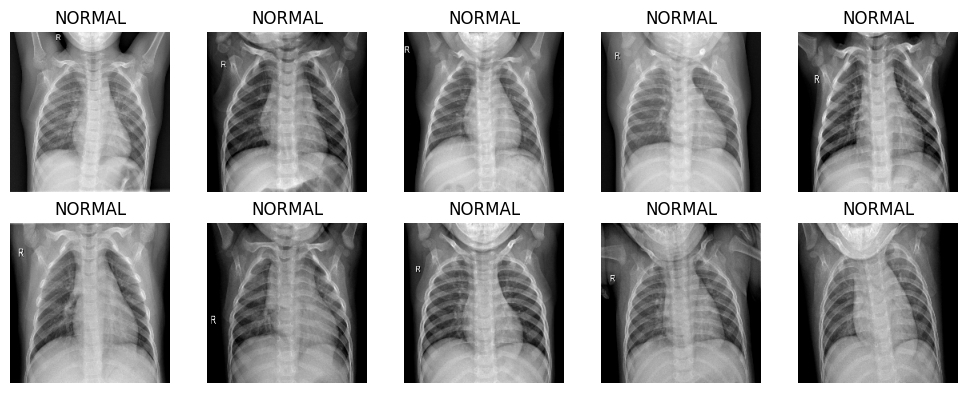

In [9]:
selected_imgs = datasetX[:10]
selected_titles = datasetY[:10]

plot_size = (2, 5)

# Afficher les images
display_imgs(selected_imgs, titles=selected_titles, plot_size=plot_size, figsize=(10, 4))

In [26]:
print(model.evaluate(testx, testy))

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.7704 - loss: 0.5198
[0.5474758148193359, 0.7713310718536377]


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step


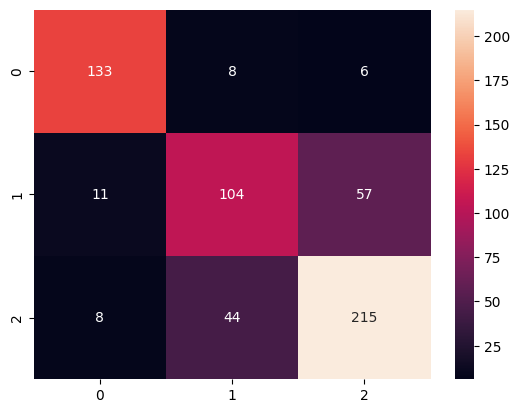

[[133   8   6]
 [ 11 104  57]
 [  8  44 215]]
recall :  0.7715521710818288
precision :  0.7716826538768985
f1score :  0.7709230913916332


In [27]:
y_pred = model.predict(testx)

y_pred_label = np.argmax(y_pred, axis=1)

cm = confusion_matrix(testy, y_pred_label)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print(cm)
recall = recall_score(testy, y_pred_label, average='macro')  # Ajout de average='macro' pour multi-classe
precision = precision_score(testy, y_pred_label, average='macro')
f1score = f1_score(testy, y_pred_label, average='macro')
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

In [30]:
from sklearn.metrics import classification_report

# Assuming y_pred_label contains the predicted class labels as shown in your code
labels = ['NORMAL', 'VIRUS PNEUMONIA', 'BACTERIA PNEUMONIA']

# Generate the classification report using the true labels and predicted labels
report = classification_report(testy, y_pred_label, target_names=labels)

print(report)

                    precision    recall  f1-score   support

            NORMAL       0.88      0.90      0.89       147
   VIRUS PNEUMONIA       0.67      0.60      0.63       172
BACTERIA PNEUMONIA       0.77      0.81      0.79       267

          accuracy                           0.77       586
         macro avg       0.77      0.77      0.77       586
      weighted avg       0.77      0.77      0.77       586

